# Selecting samples and preprocessing images for machine learning models

## 1) Load clean data

In [1]:
# Import our helper functions to resize images
import sys
import os
path = os.path.abspath('../')
sys.path.append(path)
from helpers import *

In [2]:
# Import other packages
%matplotlib inline
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

In [3]:
# Retrieve directory where we will get the raw data from
parent_directory = os.path.abspath('../')
dataset_path = os.path.join(parent_directory,'data/TACO/data')

# Retrieve directory where we will get save processed data and features
features_path = os.path.join(parent_directory,'data/features')
os.makedirs(features_path, exist_ok=True)

In this second notebook, we start by importing the original annotations dataset (*annotdata*) and the 'clean' version we produced that includes additional variables used in exploratory data analysis (*annot_df*).

In [4]:
# Read annotations file
with open("{}/annotations.json".format(dataset_path), 'r') as f:
    annotdata = json.loads(f.read())

In [5]:
# Read clean annotations file
annot_df = pd.read_csv("{}/{}".format(features_path,"clean-annotations-data.csv"))

## 2) Functions to process images for machine learning models

We have written three functions that will process our images in preparation for our machine learning models.:

- **Show annotation**: The first function simply takes an _annotation id_ and returns the image containing this annotation, without any additional transformations.
- **Crop image around annotation**: The purpose of the second function is to crop the image around the annotation (with id _annotation_id_), thus removing background elements (such as a road or a landscape). It should be easier to classify images if objects are in the centre of the image and we and remove other objects around it.
- **Create annotation mask**: The third function creates a "black and white" image showing the contour of each annotation.

### Crop image around annotation

The first step is to load the image containing the annotation of interest. Then, we recover the annotation bounding box from the annotations COCO-Json file and compute the bounding box centroid.

Next, we draw a square around this centroid and control the size of the square side with the parameter **widen_param**:

- If **widen_param** is 0, its smallest allowed value, then we will draw the smallest square possible around the annotation bounding box while retaining the entire bounding box.
- If **widen_param** is 1, its allowed largest value, then the side of the square will be equal to the side of the original image (either the width or the height, whichever is highest). Occasionally, the boundaries of this square fall outside the image itself. For example, if the object was near a corner. In that case, the cropped area is no longer square and will be rectangular. If this is the case, we add black borders around the rectangle to make it square.

The side of the final square can be controlled with the **newsize** parameter.

We demonstrate how this function works by showing an example with three values of the **widen_param** parameter.

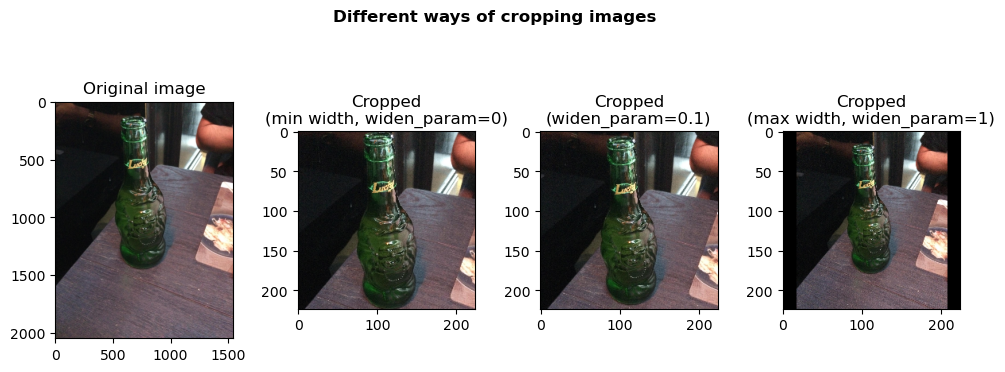

In [6]:
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

# Flatten the axes array
axes = axes.flatten()

# Display original image
axes[0].imshow(show_annotation_image(annotation_id=1, annotations=annotdata, dataset_path=dataset_path))
axes[0].set_title("Original image")

# Display cropped image with minimum width
axes[1].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=0, newsize=224, dataset_path=dataset_path))
axes[1].set_title("Cropped\n(min width, widen_param=0)")

# Display cropped image with slight widening
axes[2].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=0.1, newsize=224, dataset_path=dataset_path))
axes[2].set_title("Cropped\n(widen_param=0.1)")

# Display cropped image with maximum width
axes[3].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=1, newsize=224, dataset_path=dataset_path))
axes[3].set_title("Cropped\n(max width, widen_param=1)")

# Add title to the figure
fig.suptitle("Different ways of cropping images", fontsize=12, fontweight="bold")

# Adjust layout to fit the title properly
plt.tight_layout(rect=[0, 0, 0.98, 0.98])

# Show the plot
plt.show()

### Create image mask

The function below has two steps:

* It converts the annotation into a new image (_a mask_) showing the contours of the annotation. This was adapted from a function written by [Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/blob/master/335%20-%20Converting%20COCO%20JSON%20annotations%20to%20labeled%20mask%20images/335d-convert_coco_to_labeled_masks.py).
* Then, it crops the resulting mask image in exactly the same way as the function described above (try_square_crop).

By using these two functions, each processed image will have its equivalent mask image that exactly mirrors the original image in terms of where the object is located.

We demsonstrate how this function works below, using the same source image.

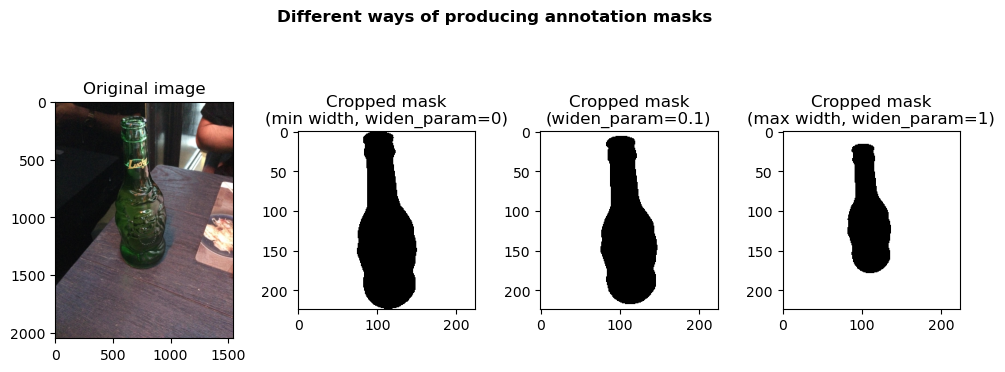

In [7]:
# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

# Flatten the axes array
axes = axes.flatten()

# Display original image with grayscale colormap
axes[0].imshow(show_annotation_image(annotation_id=1, annotations=annotdata, dataset_path=dataset_path), cmap="Greys")
axes[0].set_title("Original image")

# Display cropped mask image with minimum width
axes[1].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=0, newsize=224, dataset_path=dataset_path), cmap="Greys")
axes[1].set_title("Cropped mask\n(min width, widen_param=0)")

# Display cropped mask image with slight widening
axes[2].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=0.1, newsize=224, dataset_path=dataset_path), cmap="Greys")
axes[2].set_title("Cropped mask\n(widen_param=0.1)")

# Display cropped mask image with maximum width
axes[3].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=1, newsize=224, dataset_path=dataset_path), cmap="Greys")
axes[3].set_title("Cropped mask\n(max width, widen_param=1)")

# Add title to the figure
fig.suptitle("Different ways of producing annotation masks", fontsize=12, fontweight="bold")

# Adjust layout to fit the title properly
plt.tight_layout(rect=[0, 0, 0.98, 0.98])

# Show the plot
plt.show()

## 3) Selecting samples for machine learning models

### Selecting samples for classification model

Based on our exploratory analysis, we restrict our classification task to the following objects:

* Bottles
* Cartons
* Cups
* Cans
* Plastic film

This results in 1,561 total usable annotations. The variables useful for classification, including the labels and image and annotation id's are stored in DataFrame 'annot_df_c1'.

In [8]:
# Select a subset of the data
annot_df_c1 = annot_df.dropna(subset=['c1_label'], inplace=False)
annot_df_c1.reset_index(drop=True, inplace=True)
annot_df_c1.shape

(1561, 11)

In [9]:
# Only keep the relevant columns
annot_df_c1 = annot_df_c1[["id","image_id","category_id","c1_numlabel","c1_label"]].copy()

Some of our 1,561 annotations are in fact in the same image. For example, 340 images contain two different annotations. However, if we use our image cropping approach around each annotation bounding box, we can treat each of these as separate images.

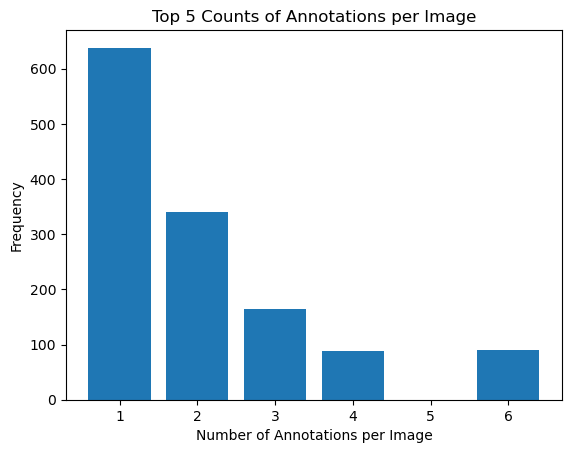

In [10]:
# Compute annotations by image
annot_df_c1["annotations_by_image"] = annot_df_c1.groupby('image_id')['id'].transform('count')

# Get the top 5 value counts
top_counts = annot_df_c1["annotations_by_image"].value_counts()[:5]

# Plotting the bar graph
plt.bar(top_counts.index, top_counts.values)
plt.xlabel('Number of Annotations per Image')
plt.ylabel('Frequency')
plt.title('Top 5 Counts of Annotations per Image')
plt.show()

For this classification problem, we choose a widen_param of 0.05 - this results in a close crop around the annotation bounding box but retains a small amount of backround elements as shown below.

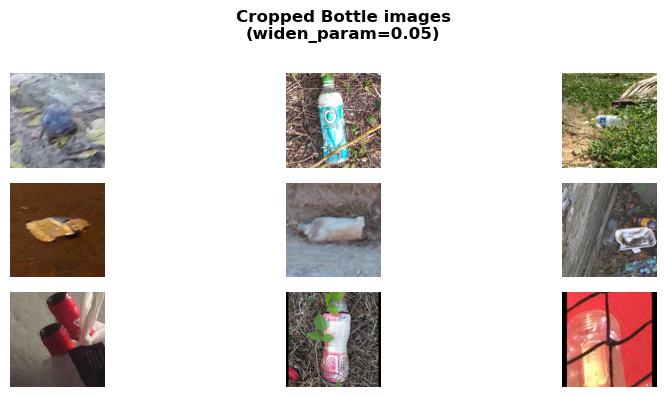

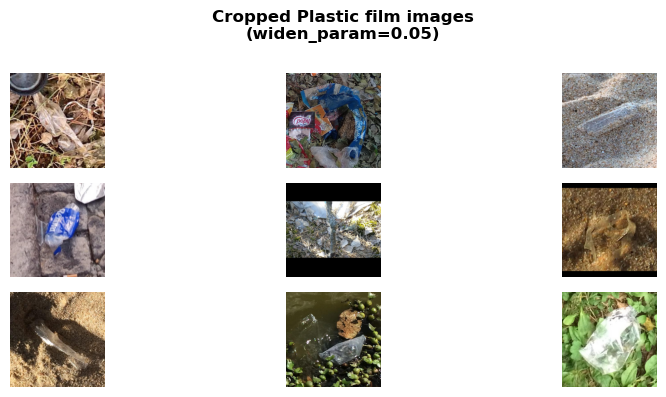

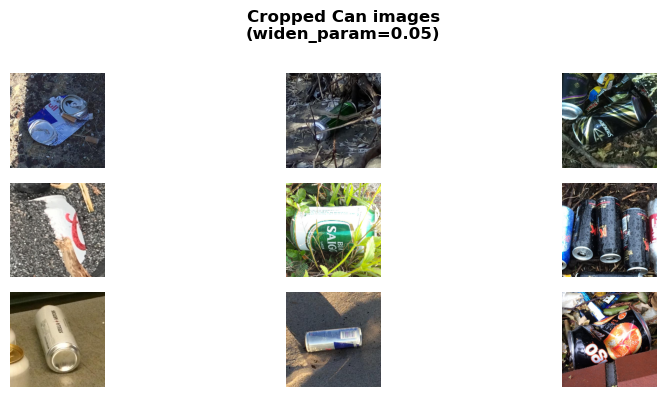

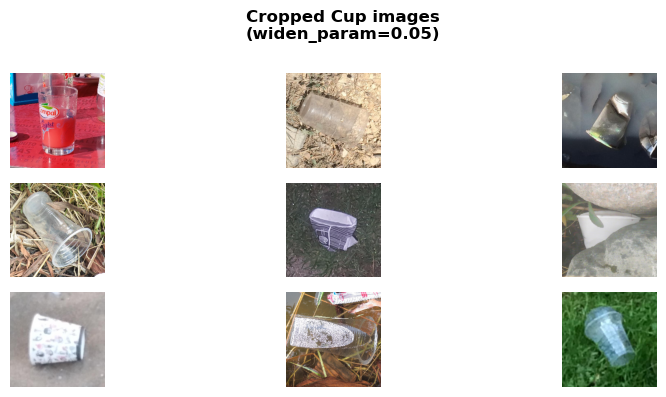

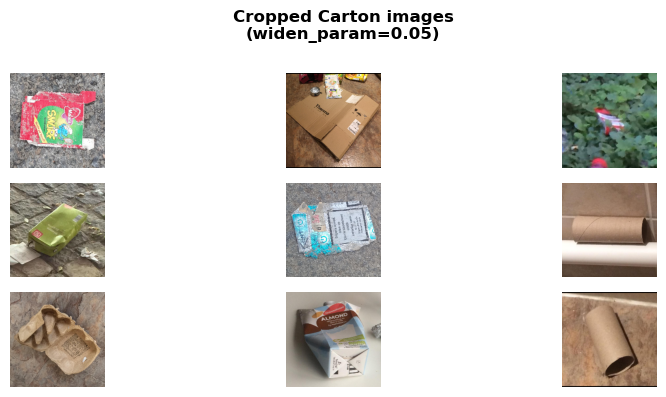

In [11]:
def plot_cropped_images(label, annotations_df, annotdata, widen_param=0.05, newsize=224, dataset_path=None):
    # Select samples for the given label
    annotations_samples = sample(list(annotations_df.loc[annotations_df.c1_label == label, "id"]), 9)
    
    # Create subplots
    fig, axes = plt.subplots(3, 3, figsize=(10, 4))
    
    # Plot cropped images
    for (annotindex, ax) in zip(annotations_samples, axes.flatten()):
        ax.imshow(try_square_crop(annotindex, annotations=annotdata, widen_param=widen_param, newsize=newsize, dataset_path=dataset_path))
        ax.set_axis_off()
    
    # Set title and adjust layout
    fig.suptitle(f"Cropped {label} images\n(widen_param={widen_param})", fontsize=12, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 0.98, 0.98])
    plt.show()

# Plot cropped images for each category
categories = ["Bottle", "Plastic film", "Can", "Cup", "Carton"]
for category in categories:
    plot_cropped_images(category, annot_df_c1, annotdata, widen_param=0.05, newsize=224, dataset_path=dataset_path)


### Selecting samples for image segmentation analysis

For our image segmentation task, we will focus on images of bottles. However, we will only work with images that have a single bottle. This leaves us with 248 images.

In [13]:
# Filter annotations DataFrame to include only annotations related to the "Bottle" supercategory
annot_df_s1 = annot_df.loc[annot_df["supercategory"].isin(["Bottle"]), :]

# Extract relevant columns and create a copy
annot_df_s1 = annot_df_s1[["id", "image_id", "category_id"]].copy()

# Count the number of annotations per image and create a new column
annot_df_s1["annotations_by_image"] = annot_df_s1.groupby('image_id')['id'].transform('count')

# Keep only images with one annotation
annot_df_s1 = annot_df_s1.loc[annot_df_s1.annotations_by_image == 1, :].copy()

# Reset index and update DataFrame shape
annot_df_s1.reset_index(drop=True, inplace=True)
annot_df_s1.shape

### Saving classification labels

In [15]:
# Save classification labels
np.savez("{}/{}".format(features_path,"classification-labels.npz"), c1=annot_df_c1, s1=annot_df_s1,
         c1_colnames=annot_df_c1.columns, s1_colnames=annot_df_s1.columns)

## 4) Process images for machine learning models

Finally, we process the images we will use in our classification and segmentation tasks. As a reminder:

* For our classification tasks, this means resizing and cropping the images in a square around the annotation bounding box and, if necessary, adding a black border.
* On top of the above, for our segmentation task, we also need to produce image masks that mirror exactly the same transformations applied to the original images.

We do this for three values of the *widen_param* parameter, so we can perform sensitivity analyses in our machine learning tasks if needed.

In [16]:
# Change the value of generate_cropped_images to True if you wish to generate the cropped images
# This only needs to be done once, as it can be time intensive
generate_cropped_images = False

In [17]:
# Only run if generate_cropped_images is True
if generate_cropped_images:
    for width in [0, 0.05, 1]:
        # Generate images for task C1, and store as a 4-dimensional numpy array
        c1_data = [try_square_crop(idx, annotations=annotdata, widen_param=width, newsize=224, dataset_path=dataset_path) for idx in list(annot_df_c1.id)]
        c1_data = np.stack(c1_data, axis=0)

        # Find the locations (indices) of images for task S1 within the set prepared for task C1 (S1 is also a subset of C1)
        # And store those images is a separate 4-dimensional numpy array
        s1_locations_in_c1 = annot_df_s1["id"].map(lambda x: np.squeeze(annot_df_c1.index[annot_df_c1.id==x]))
        s1_data = c1_data[s1_locations_in_c1,:,:,:]

        # Create binary image masks for images used in task S1
        # And store those images in a separate 4-dimensional numpy array
        s1_masks = [mask_and_square_crop(idx, annotations=annotdata, widen_param=width, newsize=224, dataset_path=dataset_path) for idx in list(annot_df_s1.id)]
        s1_masks = np.stack(s1_masks, axis=0)

        # Create folder to store the transformed images and masks
        destination = "{}/{}".format(features_path,"widen_param_{}".format(width))
        os.makedirs(destination, exist_ok=True)

        # Save data
        np.savez("{}/{}".format(destination,"classification-images.npz"), c1=c1_data, s1=s1_data, s1_masks=s1_masks)